# IoT Project

In [818]:
import numpy as np
import pandas as pd
from collections import defaultdict
from IPy import IP as IPy
import pprint
from sklearn import preprocessing
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import warnings
import csv

warnings.filterwarnings('ignore')

from dask.distributed import Client, progress
import dask.dataframe as dd
client = Client('127.0.0.1:8786')
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 16 Memory: 68.72 GB


#### Internet IP address <-> Organization mapping

In [819]:
ASN_df = pd.read_csv("./ip2asn-combined.tsv", sep='\t', header=None)
ASN_df.columns = ['start','end','asn','country','organization']

# remove all the "Not routed" rows
ASN_df = ASN_df[ASN_df['organization'] != 'Not routed']

# add numerical representation for the start and end IP range for faster org search later
ASN_df['start.dec'] = ASN_df['start'].apply(lambda x: float(IPy(x).strDec()))
ASN_df['end.dec'] = ASN_df['end'].apply(lambda x: float(IPy(x).strDec()))

## Device labeling  

Makes the labels for the devices to be used later for supervised training and test sets.

In [820]:
# baseline 
tshark_cmd = "-T fields -E header=y -e frame.number -e frame.time -e frame.len -e frame.protocols"

# ethernet layer
#tshark_cmd += " -e eth.src_resolved -e eth.dst_resolved"
tshark_cmd += " -e eth.src -e eth.dst -e eth.dst_resolved"

#add IP/TCP/UDP/ICMP layers
tshark_cmd += " -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport -e udp.srcport -e udp.dstport"

# add DSN / mDNS layer
tshark_cmd += " -e dns.qry.name -e dns.resp.name -e dns.cname -e dns.a"

# add HTTP layer
tshark_cmd += " -e http.request.method -e http.request.uri -e http.user_agent -e http.host"

# add SSL certificate layer
tshark_cmd += " -e x509sat.printableString -e x509sat.uTF8String"

In [821]:
#!tshark -tud -N m -r ./packet_capture.pcap {tshark_cmd} > daghan.csv
#!tshark -tud -N m -r ./IoT_Trafﬁc_UNSW_Sydney/train_large_2.pcap {tshark_cmd} > packets_train_large_2.csv

## Load the packet data

In [822]:
#df = pd.read_csv("./packets_train_large_2.csv", sep='\t')
df = pd.read_csv("./packets_train_1M.csv", sep='\t')
#df = pd.read_csv("./daghan.csv", sep='\t')
#df = df.append(df2)

## Load known devices labels

In [872]:
OUI_df = pd.read_csv('oui.csv')
OUI_df['Registry'] = OUI_df['Registry'].apply(lambda x: x.lower())
OUI_df['Assignment'] = OUI_df['Assignment'].apply(lambda x: x.lower())
OUI_df['Organization Name'] = OUI_df['Organization Name'].apply(lambda x: x.lower())
#OUI_df['Organization Address'] = OUI_df['Organization Address'].apply(lambda x: x.lower())

In [873]:
OUI_df.head()

,Registry,Assignment,Organization Name,Organization Address
0,ma-l,e043db,"shenzhen viewat technology co.,ltd.","9A,Microprofit,6th Gaoxin South Road, High-Tec..."
1,ma-l,2405f5,integrated device technology (malaysia) sdn. bhd.,"Phase 3, Bayan Lepas FIZ Bayan Lepas Penang MY..."
2,ma-l,3cd92b,hewlett packard,11445 Compaq Center Drive Houston US 77070
3,ma-l,9c8e99,hewlett packard,11445 Compaq Center Drive Houston US 77070
4,ma-l,b499ba,hewlett packard,11445 Compaq Center Drive Houston US 77070


In [874]:
daghan_devices = pd.read_csv('known_devices.csv').drop("Description", axis = 1)
sydney_devices = pd.read_csv('sydney_devices.csv')
known_devices = sydney_devices.append(daghan_devices)
known_devices['MAC address'] = known_devices['MAC address'].apply(lambda x: x.lower().strip())
known_devices['Manufacturer'] = known_devices['Manufacturer'].apply(lambda x: x.lower().strip())
known_devices['Device Type'] = known_devices['Device Type'].apply(lambda x: x.lower().strip())
known_devices['OUI'] = known_devices['MAC address'].apply(lambda x: ''.join(x.lower().split(':')[0:3]))
known_devices['Manufacturer Device Type'] = ([' '.join(row) for row in 
                        zip(known_devices["Manufacturer"],known_devices["Device Type"])])
known_devices['Manufacturer Device Type'] = known_devices['Manufacturer Device Type'].apply(lambda x: x.strip())

In [875]:
known_devices.head()

,MAC address,Manufacturer,Device Type,OUI,Manufacturer Device Type
0,d0:52:a8:00:67:5e,samsung,smart things,d052a8,samsung smart things
1,44:65:0d:56:cc:d3,amazon,echo,44650d,amazon echo
2,70:ee:50:18:34:43,netatmo,welcome,70ee50,netatmo welcome
3,f4:f2:6d:93:51:f1,tp-link,camera,f4f26d,tp-link camera
4,00:16:6c:ab:6b:88,samsung,camera,00166c,samsung camera


## Function for determining traffic zone  
This function determines whether the IP address belongs to a device on the local network or a server on the Internet, according to RFC1918: https://tools.ietf.org/html/rfc1918

In [876]:
def determineZone(ip):
    """
    This function determines if the IP 
    address is internal or public 
    according to RFC1918
    """    
    if pd.notna(ip):
        return IPy(ip.split(',')[0]).iptype()
    else:
        return ip

## Function for extracting sentences  
This function goes through a packet and contructs a sentence of the form:  
\[device: < manufacturer > identifier: < last 6 char of MACID > | service: < Internet Autonomous Service > \]  port: < int > protocol: < protocol_type > size: < packet_size > \[device: < manufacturer > identifier: < last 6 char of MACID > | service: < Internet Autonomous Service >\] \[Optional Information\]  
    
### Example
device: dropcam identifier: 2fe4b2 port: 46330 protocol: ssl size: 156 service: dropcam port: 443

In [877]:
def protoLang(line):
    proto = line['protocol'] 
    size = "size: " + str(line['frame.len'])
    message = ""
    
    try:
        
        ########################################
        ### Extract base line protocol       ###
        ########################################
        
        #UDP based?
        if line['frame.protocols'].find('udp') > 0:     
            src =  " ".join(['device:',line['org.src'], 'identifier:', str(line['tail.src'])]) if line['zone.src'] == 'PRIVATE' \
                else " ".join(['service:',line['org.src']])
            srcport = 'port: ' + str(int(line['udp.srcport']))
            dst =  "" if pd.isna(line['org.dst']) \
                    else (" ".join(['device:', line['org.dst'],'identifier:', str(line['tail.dst'])]) if line['zone.dst'] == 'PRIVATE' \
                            else (" ".join(['service:',line['org.src']]) if line['zone.dst'] == 'PUBLIC' else ''))
            dstport = 'port: ' + str(int(line['udp.dstport']))
        
        #TCP based?
        if line['frame.protocols'].find('tcp') > 0:     
            src =  " ".join(['device:', line['org.src'], 'identifier:', str(line['tail.src'])]) if line['zone.src'] == 'PRIVATE' \
                else " ".join(['service:',line['org.src']])
            srcport = 'port: ' + str(int(line['tcp.srcport']))
            dst =  "" if pd.isna(line['org.dst']) \
                    else (" ".join(['device:', line['org.dst'],'identifier:', str(line['tail.dst'])]) if line['zone.dst'] == 'PRIVATE' \
                            else (" ".join(['service:',line['org.src']]) if line['zone.dst'] == 'PUBLIC' else ''))
            dstport = 'port: ' + str(int(line['tcp.dstport']))
        
        ## ICMPv6
        ## TODO: There is more information to be extracted here
        elif proto == 'icmpv6':
            src =  " ".join(['device:',line['org.src'],'identifier:',line['tail.src']]) 
            return " ".join([src,proto,size]).lower()
        
        
        #IP (L3) that is neither of those
        elif line['frame.protocols'].find('ip') > 0:
            src =  " ".join(['device:', line['org.src'],'identifier:',line['tail.src']]) if line['zone.src'] == 'PRIVATE' \
                    else " ".join(['service:', line['org.src']])
            dst =  "" if pd.isna(line['org.dst']) \
                    else (" ".join(['device:', line['org.dst'],'identifier:',line['tail.dst']]) if line['zone.dst'] == 'PRIVATE' \
                            else (" ".join(['service:', line['org.src']]) if line['zone.dst'] == 'PUBLIC' else ''))
        
        #L2
        elif line['frame.protocols'].find('eth') > 0:
            src =  " ".join(['device:', line['org.src'],'identifier:',line['tail.src']]) 
            dst =  " ".join(['device:', line['org.dst'],'identifier:',line['tail.dst']]) if pd.notna(line['org.dst']) else ''
        
        #this should very rarely happen, if at all!
        else:
            print("undetected protocol(1): {}".format(line))
            return ""
        
        
        
        ########################################
        ### Extract higher layer protocol    ###
        ### and additional meta data         ###
        ########################################        
         # x509ce (certificate exchange)
        if line['frame.protocols'].find('x509') > 0:
            proto = "protocol: " + proto
            x509ce_message = ''
            if pd.notna(line['x509sat.printableString']):
                x509ce_message += line['x509sat.printableString']
            if pd.notna(line['x509sat.uTF8String']):
                x509ce_message += line['x509sat.uTF8String']
            return " ".join([src,srcport,proto,size,dst,dstport,x509ce_message]).lower()
        
        ## ssl 
        elif proto == 'ssl':
            proto = "protocol: " + proto
            return " ".join([src,srcport,proto,size,dst,dstport]).lower()
                
        
        ## tcp:data
        elif line['frame.protocols'].find('tcp:data') > 0:
            proto = "protocol: tcp:data"
            return " ".join([src,srcport,proto,size,dst,dstport]).lower()
        
        ## tcp:stun
        ## TODO: stun.att.software "stun.att.realm": "belkin.org",
        elif line['frame.protocols'].find('tcp:stun') > 0:
            proto = 'protocol: tcp:stun'
            return " ".join([src,srcport,proto,size,dst,dstport]).lower()
        
        ## upd:data
        ## TODO: Detect broadcasts
        elif line['frame.protocols'].find('udp:data') > 0:
            proto = 'protocol: udp:data'
            return " ".join([src,srcport,proto,size,dst,dstport]).lower()
        
        ## udp:nbns (netbios)
        ## TODO: nbns.name": "MACBOOKAIR-7040<00> (Workstation\/Redirector)",
        elif line['frame.protocols'].find('udp:nbns') > 0:
            proto = 'protocol: udp:nbns'
            return " ".join([src,srcport,proto,size]).lower()
        
        ## upd:bootp (dhcp)
        ## TODO: "bootp.option.hostname": "amazon-c4475da2a"
        ## TODO: "bootp.type": "2" (1 is request, 2 is reply)
        ## if it is a reply, add the dst IP address too
        elif line['frame.protocols'].find('udp:bootp') > 0:
            proto = 'protocol: udp:bootp'
            return " ".join([src,srcport,proto,size]).lower()
        
        ## udP:gquic
        ## TODO: "gquic.tag.sni": "0.docs.google.com"
        ## TODO: "gquic.tag.uaid": "Chrome\/65.0.3325.181 Intel Mac OS X 10_13_3" 
        ## TODO: "gquic.tag": "CHLO" (client hello)
        elif line['frame.protocols'].find('udp:quic') > 0:
            proto = 'protocol: udp:gquic'
            return " ".join([src,srcport,proto,size,dst,dstport]).lower()
        
        ## ssdp (simple service discovery protocol)
        ## TODO: http.server: "Linux UPnP\/1.0 Sonos\/41.3-50131 (ZPS12)
        ## TODO: http.unknown_header: "HOUSEHOLD.SMARTSPEAKER.AUDIO: Sonos_hOcMvZ0JBvDVZz7BXZc5ILQAT5.Cd7MOjIUy3HWHWEXItIZ\\r\\n",
        ## TODO: http.request.full_uri: "http:\/\/239.255.255.250:1900*",
        elif proto == 'ssdp':
            proto = "protocol: " + proto
            return " ".join([src,srcport,proto,size,dst,dstport]).lower()
        
        ## db-lsp-disc:json (Dropbox Lan sync Discovery Protocol)
        ## TODO: Detect and use Broadcast
        ## TODO: eth.addr_resolved": "Broadcast"
        elif line['frame.protocols'].find('db-lsp-disc:json') > 0:
            proto = 'protocol: db-lsp-disc'
            return " ".join([src,srcport,proto,size,dstport]).lower()
        
        ## ntp (network time protocol)
        elif proto == 'ntp':
            proto = "protocol: " + proto
            return " ".join([src,srcport,proto,size,dst,dstport]).lower()
        
        ## STP (spanning tree protocol)
        elif proto == 'stp':
            proto = "protocol: " + proto
            return " ".join([src,proto,size]).lower()
        
        ## mdns
        elif proto == 'mdns':
            proto = "protocol: " + proto
            mdns_string =   (line['dns.qry.name'] + " " if pd.notna(line['dns.qry.name']) else '') + \
                            (line['dns.resp.name'] + " " if pd.notna(line['dns.resp.name']) else '') +\
                            (line['dns.cname'] + " " if pd.notna(line['dns.cname']) else '') + \
                            (line['dns.a'] if pd.notna(line['dns.a']) else '')    
            return " ".join([src,srcport,proto,size,mdns_string]).lower()
        
        ## igmp
        ##TODO: look into IGMP
        elif proto == 'igmp':
            proto = "protocol: " + proto
            return " ".join([src,proto,dst]).lower()
        
        ## dns
        elif proto == 'dns':
            proto = "protocol: " + proto
            dns_string =   (line['dns.qry.name'] + " " if pd.notna(line['dns.qry.name']) else '') + \
                            (line['dns.resp.name'] + " " if pd.notna(line['dns.resp.name']) else '') +\
                            (line['dns.cname'] + " " if pd.notna(line['dns.cname']) else '') + \
                            (line['dns.a'] if pd.notna(line['dns.a']) else '')
            return " ".join([src,srcport,proto,size,dst,dstport,dns_string]).lower()

        ## http 
        elif proto == 'http':
            proto = "protocol: " + proto
            payload = (line['http.request.method'] + " " if pd.notna(line['http.request.method']) else '') + \
                    (line['http.request.uri'] + " " if pd.notna(line['http.request.uri']) else '') + \
                    (line['http.user_agent'] + " " if pd.notna(line['http.user_agent']) else '') + \
                    (line['http.host'] if pd.notna(line['http.host']) else '')
            return " ".join([src,srcport,proto,size,dst,dstport,payload]).lower()
        
        ## http:data
        ## TODO: add http.file_data content
        elif line['frame.protocols'].find('http:data') > 0:
            proto = 'protocol: http:data'
            payload = (line['http.request.method'] + " " if pd.notna(line['http.request.method']) else '') + \
                    (line['http.request.uri'] + " " if pd.notna(line['http.request.uri']) else '') + \
                    (line['http.user_agent'] + " " if pd.notna(line['http.user_agent']) else '') + \
                    (line['http.host'] if pd.notna(line['http.host']) else '')
            return " ".join([src,srcport,proto,size,dst,dstport,payload]).lower()
        
        ## http:media
        ## TODO: add  http.content_type , http.content_length
        elif line['frame.protocols'].find('http:media') > 0:
            proto = 'protocol: http:media'
            return " ".join([src,srcport,proto,size,dst,dstport]).lower()
        
        
        ## icmp:data
        ## TODO: Consider adding icmp.type to the frame / protocol language
        ## TODO: Detect broadcast
        elif line['frame.protocols'].find('icmp:data') > 0:
            proto = 'protocol: icmp:data'
            return " ".join([src,proto,size,dst]).lower()
        
        elif proto == 'arp':
            #return " ".join([src,proto,size,dst])
            return ""
        
        ## ethertype:data
        elif line['frame.protocols'].find('ethertype:data') > 0:
            proto = 'protocol: ethertype:data'
            return " ".join([src,proto,size]).lower()
        
        # undetected protocols
        else:
            #is it based on UDP or TCP?
            proto = "protocol: " + proto
            if line['frame.protocols'].find('udp') +\
                line['frame.protocols'].find('tcp') > 0:
                return " ".join([src,srcport,proto,size,dst,dstport]).lower()
            elif line['frame.protocols'].find('ip')> 0:
                return " ".join([src,proto,size,dst]).lower()
            elif line['frame.protocols'].find('eth')> 0:
                return " ".join([src,proto,size,dst]).lower()
            else:
                print("undetected protocol(2): {}".format(str(line)))
                return " ".join([src,proto,size,dst]).lower()
            
    except ValueError:
        print('Exception!!')
        print(line)

## Function for preprocessing the packet based dataframe  
This is a function that is putting everything together.   

1- It takes a data frame as input, where each row is one packet, which a direct import from tshark.  
2- It parallelizes it using DASK.  
3- Creates additional features like Source and Destination Zones and OUIs.  
4- Creates the protocol sentence for each row.  
5- Aggregatest and merges the dataframes based on source MAC IDs (this part is complicated so you should read the inline comments in the function below.  


In [888]:
def preprocessDF(df):
    df['oui.src'] = df['eth.src'].apply(lambda x: ''.join(x.lower().split(':')[0:3]))
    df['tail.src'] = df['eth.src'].apply(lambda x: ''.join(x.lower().split(':')[3:6]))
    df['oui.dst'] = df['eth.dst'].apply(lambda x: ''.join(x.lower().split(':')[0:3]))
    df['tail.dst'] = df['eth.dst'].apply(lambda x: ''.join(x.lower().split(':')[3:6]))
    
    #create dask frame
    df = dd.from_pandas(df, npartitions=8)
    
    #add OUI
    df = df.merge(OUI_df[list(['Assignment', 'Organization Name'])], 
             left_on = 'oui.src',  right_on= 'Assignment', how = 'left').drop(['Assignment'], axis = 1)
    df = df.rename(columns={'Organization Name':'org.src'})

    df = df.merge(OUI_df[list(['Assignment', 'Organization Name'])], 
             left_on = 'oui.dst',  right_on= 'Assignment', how = 'left').drop(['Assignment'], axis = 1)
    df = df.rename(columns={'Organization Name':'org.dst'})
    
    # let's get rid of white spaces
    df['org.src'] = df['org.src'].apply(lambda x: x.replace('.','').replace(',','').replace(" ", "-") if pd.notna(x) else x, meta = str)
    df['org.dst'] = df['org.dst'].apply(lambda x: x.replace('.','').replace(',','').replace(" ", "-") if pd.notna(x) else x, meta = str)
    
    # clean up org and tail for dst columns
    df['org.dst'] = df['org.dst'].fillna('')
    df['tail.dst'] = df[['org.dst','tail.dst','eth.dst_resolved']].apply(lambda row: row['tail.dst'] if (row['org.dst'] != '') \
                                                                     else row['eth.dst_resolved'], axis = 1, meta = str)
    # adding private (local) and public (internet) traffic zones
    df['zone.src'] = df['ip.src'].apply(lambda x: determineZone(x), meta = str)
    df['zone.dst'] = df['ip.dst'].apply(lambda x: determineZone(x), meta = str)
    
    # clean up IP addresses that have multiple source or dest values
    df['ip.src'] = df['ip.src'].apply(lambda x: x.split(',')[0] if pd.notna(x) else x, meta = str)
    df['ip.dst'] = df['ip.dst'].apply(lambda x: x.split(',')[0] if pd.notna(x) else x, meta = str)
    
    # the communication protocol column
    df['protocol'] = df['frame.protocols'].apply(lambda x: x.split(':')[-1], meta = str)
    
    # create a list of public IP addresses that we need to resolve
    public_IPs = set()
    public_IPs_orgs = {}
    for index,row in df.iterrows():
        if (row['zone.src'] == "PUBLIC"):
            public_IPs.add(row['ip.src'])
        if (row['zone.dst'] == "PUBLIC"):
            public_IPs.add(row['ip.dst'])
    
    # let's look up these public IP addresses in our db and replace with the service name
    for ip in public_IPs:
        try:
            public_IPs_orgs[ip] = ASN_df[(ASN_df['start.dec'] <= float(IPy(ip).strDec())) & 
                                    (ASN_df['end.dec'] >= float(IPy(ip).strDec()))]['organization']\
                                    .values[0].split(' ')[0]
        except:
            #print(ip)
            public_IPs_orgs[ip] = 'UNLISTED'

    # let's replace org data for public IPs based on the ASN information
    df['org.src'] = df[['zone.src','ip.src','org.src']].apply(lambda x: ( public_IPs_orgs[x['ip.src']] if x['zone.src'] == "PUBLIC" else x['org.src']), axis=1, meta = str)
    df['org.dst'] = df[['zone.dst','ip.dst','org.dst']].apply(lambda x: ( public_IPs_orgs[x['ip.dst']] if x['zone.dst'] == "PUBLIC" else x['org.dst']), axis=1, meta = str)
   
    #df['org.src'] = df['org.src'].fillna("UNKNOWN")
    #df['tail.src'] = df['tail.src'].fillna("UNKNOWN")
    #df['org.dst'] = df['org.dst'].fillna("UNKNOWN")
    #df['tail.dst'] = df['tail.dst'].fillna("UNKNOWN")

    
     # let's create a sentence for each packet
    df['sentence'] = df.apply(lambda line: protoLang(line), axis=1, meta = str)
    
    
    # Aggregating these sentences for each device is non-trivial. 
    # More can be found here: 
    # https://docs.google.com/spreadsheets/d/1UCClhmFm9nZc6VUr5XV_rMtQ90C3vgFb4nJ6DG2iF_g
    
    # Or just read on! 
    
    # Source   Destination
    # Private  Private   => L3: Local device to local device (this one is actually very tricky, refer to the link above)
    # Private  Public    => L3: Local device to Internet
    # Public   Private   => L3: Internet to local device, register for the eth.dst
    # Public   Public    => Shouldn't be possible, ignore
    # NaN      whatever  => If the source device has no public or private zone (therefore NaN), that means it doesn't have 
    #                       an IP address, which means it is almost certainly layer 2 (ethernet traffic)
    #                       L2: Local device to local device, register for eth.src         

    # 3 aggregation
    # 1- source = Private (local to local and local to Internet, register for eth.src)
    # 2- source = Public  (Internet to local, register for the eth.dst)
    # 3- source = NA  (L2, the local device can be the receiver or sender, register for eth.src)


    
    df_agg1 = df[(df['zone.src'] == 'PRIVATE') & (df['sentence'] != '')][['eth.src','sentence','org.src','tail.src']]
    df_agg2 = df[(df['zone.src'] == 'PUBLIC')  & (df['sentence'] != '')][['eth.dst','sentence','org.dst','tail.dst']]
    df_agg2.columns = ['eth.src','sentence','org.src','tail.src']
    df_agg3 = df[(df['zone.src'] != 'PRIVATE') & (df['zone.src'] != 'PUBLIC') & (df['sentence'] != '')][['eth.src','sentence','org.src','tail.src']]

    final_agg = df_agg1.append(df_agg2)
    return final_agg.append(df_agg3)
    #return df_agg3




## Step1: Load training data

In [889]:
#df = pd.read_csv("./packets_train_large_2.csv", sep='\t')
df = pd.read_csv("./packets_train_1M.csv", sep='\t')
#df = pd.read_csv("./daghan.csv", sep='\t')
#df = df.append(df2)

In [890]:
training_df = preprocessDF(df)

In [891]:
training_df = training_df.merge(known_devices[list(['MAC address','Manufacturer Device Type'])], 
             left_on = 'eth.src',  right_on= 'MAC address', how = 'inner').drop(['MAC address'], axis = 1)

In [892]:
training_df.head()

,eth.src,sentence,org.src,tail.src,Manufacturer Device Type
0,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker
1,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker
2,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker
3,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker
4,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker


In [893]:
training_df = training_df.compute()
training_df.to_csv("post_step1.csv")

In [895]:
len(training_df)

922649

## Step2: Load test data

In [896]:
df = pd.read_csv("./daghan.csv", sep='\t')
test_df = preprocessDF(df)
test_df = test_df.merge(known_devices[list(['MAC address','Manufacturer Device Type'])], 
             left_on = 'eth.src',  right_on= 'MAC address', how = 'inner').drop(['MAC address'], axis = 1)
test_df = test_df.compute()
test_df.to_csv("post_step2.csv")
test_df.head()

,eth.src,sentence,org.src,tail.src,Manufacturer Device Type
0,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 595...,apple-inc,5a7040,apple computer
1,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 595...,apple-inc,5a7040,apple computer
2,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 595...,apple-inc,5a7040,apple computer
3,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 596...,apple-inc,5a7040,apple computer
4,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 582...,apple-inc,5a7040,apple computer


## Step3: Create Label encodings

In [897]:
le = preprocessing.LabelEncoder()
le.fit(training_df['Manufacturer Device Type'].append(test_df['Manufacturer Device Type']))
training_df['label'] = le.transform(training_df['Manufacturer Device Type'])
training_df['label'] = training_df['label'].apply(lambda x: '__label__' + str(x))
test_df['label'] = le.transform(test_df['Manufacturer Device Type'])
test_df['label'] = test_df['label'].apply(lambda x: '__label__' + str(x))

In [898]:
training_df.head()

,eth.src,sentence,org.src,tail.src,Manufacturer Device Type,label
0,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker,__label__23
1,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker,__label__23
2,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker,__label__23
3,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker,__label__23
4,18:b7:9e:02:20:44,device: invoxia identifier: 022044 port: 40234...,invoxia,022044,triby speaker,__label__23


In [899]:
test_df.head()

,eth.src,sentence,org.src,tail.src,Manufacturer Device Type,label
0,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 595...,apple-inc,5a7040,apple computer,__label__2
1,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 595...,apple-inc,5a7040,apple computer,__label__2
2,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 595...,apple-inc,5a7040,apple computer,__label__2
3,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 596...,apple-inc,5a7040,apple computer,__label__2
4,84:38:35:5a:70:40,device: apple-inc identifier: 5a7040 port: 582...,apple-inc,5a7040,apple computer,__label__2


## Step4: Create NLP text for fasttext

In [900]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(training_df, test_size=0.2)
#train[['label','sentence']].to_csv('fast_train6.txt', header=None, index=None, sep=' ')
#test[['label','sentence']].to_csv('fast_test6.txt', header=None, index=None, sep=' ')

#training2_df = training_df.append(test_df)
#training2_df[['label','sentence']].to_csv('fast_train7.txt', header=None, index=None, sep=' ')

training_df[['label','sentence']].to_csv('fast_train7.txt', header=None, index=None, sep=' ')



# test_df[['label','sentence']].to_csv('fast_test7.txt', header=None, index=None, sep=' ')
test_df['sentence'].to_csv('fast_predict7.txt', header=None, index=None, sep=' ')


In [901]:
print('First 2 lines of the training text')
!head -n 2 fast_train7.txt
print()
#print('First 2 lines of the test text')
#!head -n 2 fast_test7.txt
#print()
print('First 2 lines of the prediction text')
!head -n 2 fast_predict7.txt

First 2 lines of the training text
__label__23 "device: invoxia identifier: 022044 port: 40234 protocol: tcp:data size: 70 service: invoxia port: 5228"
__label__23 "device: invoxia identifier: 022044 port: 40234 protocol: tcp size: 66 service: invoxia port: 5228"

First 2 lines of the prediction text
"device: apple-inc identifier: 5a7040 port: 59554 protocol: ssl size: 172 service: apple-inc port: 443"
"device: apple-inc identifier: 5a7040 port: 59554 protocol: ssl size: 1454 service: apple-inc port: 443"


## Step5: Train the model

In [902]:
!../fastText/fasttext supervised -input fast_train7.txt -output model7 -label __label__

Read 14M words
Number of words:  25354
Number of labels: 22
Progress: 100.0% words/sec/thread:  471115 lr:  0.000000 loss:  0.006230 ETA:   0h 0m ETA:   0h 0m


## Step6: Test the model
We are going to test the model training on the Sydney data against my home (Daghan) network

In [903]:
#!../fastText/fasttext test model7.bin fast_test7.txt

In [904]:
!../fastText/fasttext predict model7.bin fast_predict7.txt > fast_test7_post_predictions.txt

## Validating the results

In [928]:
validate_df = pd.read_csv('fast_test7_post_predictions.txt', header = None, sep=' ')
validate_df.columns = ['predicted_label']
validate_df['predicted_label'] = validate_df['predicted_label'].replace({'__label__':''}, regex=True)
validate_df['true_label'] = test_df['label'].replace({'__label__':''}, regex=True).values
validate_df['predicted_label'] = validate_df['predicted_label'].apply(lambda x: le.inverse_transform(int(x)))
validate_df['true_label'] = validate_df['true_label'].apply(lambda x: le.inverse_transform(int(x)))
validate_df['eth'] = test_df['eth.src'].values
validate_df['oui'] = validate_df['eth'].apply(lambda x: "".join(x.split(':')[0:3]))
validate_df['org.src'] = test_df['org.src'].values
validate_df['tail.src'] = test_df['tail.src'].values
validate_df['predicted_manufacturer'] = validate_df['predicted_label'].apply(lambda x: x.split(' ')[0])
validate_df['sentence'] = test_df['sentence'].values

In [929]:
validate_df.head()

,predicted_label,true_label,eth,oui,org.src,tail.src,predicted_manufacturer,sentence
0,apple iphone,apple computer,84:38:35:5a:70:40,843835,apple-inc,5a7040,apple,device: apple-inc identifier: 5a7040 port: 595...
1,apple iphone,apple computer,84:38:35:5a:70:40,843835,apple-inc,5a7040,apple,device: apple-inc identifier: 5a7040 port: 595...
2,apple iphone,apple computer,84:38:35:5a:70:40,843835,apple-inc,5a7040,apple,device: apple-inc identifier: 5a7040 port: 595...
3,apple iphone,apple computer,84:38:35:5a:70:40,843835,apple-inc,5a7040,apple,device: apple-inc identifier: 5a7040 port: 596...
4,apple iphone,apple computer,84:38:35:5a:70:40,843835,apple-inc,5a7040,apple,device: apple-inc identifier: 5a7040 port: 582...


In [930]:
len(validate_df[validate_df.predicted_label == validate_df.true_label])/len(validate_df)

0.06821480406386067

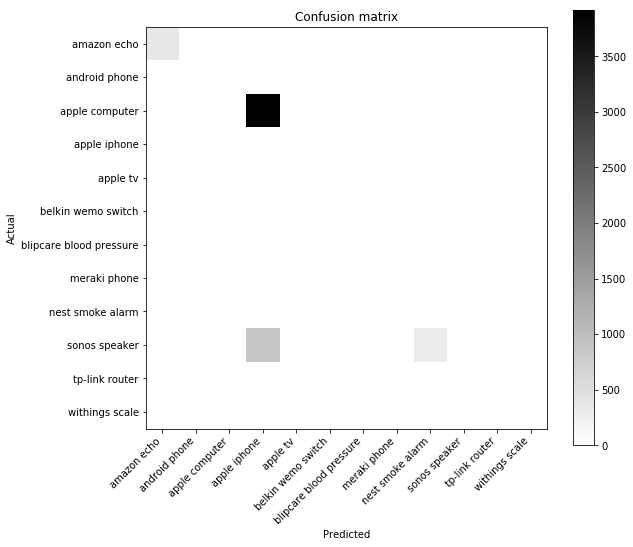

In [931]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

confusion_matrix = ConfusionMatrix(validate_df.true_label,validate_df.predicted_label)
confusion_matrix.plot()

# Prediction / Error Analysis

In [932]:
classified_by_true_label_df = validate_df.groupby(['true_label','predicted_label']).apply(len).to_frame()
classified_by_true_label_df.columns = ['total_samples']
classified_by_true_label_df['correct_prediction'] = classified_by_true_label_df.index.map(lambda x: x[0] == x[1])
classified_by_true_label_df['total_correct'] = classified_by_true_label_df['correct_prediction'] * classified_by_true_label_df['total_samples']
classified_by_true_label_df['total_incorrect'] = (1-classified_by_true_label_df['correct_prediction']) * classified_by_true_label_df['total_samples']


#validate_df.groupby('predicted_label').apply(lambda df:  sum(df['true_label'] == df['predicted_label']))
classified_by_true_label_df

total_samples correct_prediction  \
true_label         predicted_label                                             
amazon echo        amazon echo                        372               True   
apple computer     android phone                       12              False   
                   apple iphone                      3914              False   
                   tp-link router                       7              False   
                   withings scale                       2              False   
apple tv           apple iphone                         5              False   
                   withings scale                       8              False   
belkin wemo switch belkin wemo switch                   4               True   
meraki phone       blipcare blood pressure              2              False   
                   nest smoke alarm                     8              False   
sonos speaker      android phone                        3              False   
                   apple iphone                       858              False   
                   blipcare blood pressure              1              False   
                   nest smoke alarm                   316              False   

                                           total_correct total_incorrect  
true_label         predicted_label                                        
amazon echo        amazon echo                       372               0  
apple computer     android phone                       0              12  
                   apple iphone                        0            3914  
                   tp-link router                      0               7  
                   withings scale                      0               2  
apple tv           apple iphone                        0               5  
                   withings scale                      0               8  
belkin wemo switch belkin wemo switch                  4               0  
meraki phone       blipcare blood pressure             0               2  
                   nest smoke alarm                    0               8  
sonos speaker      android phone                       0               3  
                   apple iphone                        0             858  
                   blipcare blood pressure             0               1  
                   nest smoke alarm                    0             316

 ## Observation 
The model does **extremely well** with previously seen type of devices but does **very poorly** with devices not seen before.

Our strategy is to devise a filtering algorigthm to avoid making a prediction with these devices.

## Filtering obvious mistakes  
Our strategy is to compare the OUI information from the predicted packets / sentences to the known devices. If a device is known to be Apple (but unclear whether it is an iPhone or MacBook) but is predicted to be an Amazon Alexa device, then we know we can safely discard that prediction.


In [934]:
sydney_devices = pd.read_csv('sydney_devices.csv')
sydney_devices['MAC address'] = sydney_devices['MAC address'].apply(lambda x: x.lower().strip())
sydney_devices['Manufacturer'] = sydney_devices['Manufacturer'].apply(lambda x: x.lower().strip())
sydney_devices['Device Type'] = sydney_devices['Device Type'].apply(lambda x: x.lower().strip())
sydney_devices['OUI'] = sydney_devices['MAC address'].apply(lambda x: ''.join(x.lower().split(':')[0:3]))
sydney_devices['Manufacturer Device Type'] = ([' '.join(row) for row in 
                        zip(sydney_devices["Manufacturer"],sydney_devices["Device Type"])])
sydney_devices['Manufacturer Device Type'] = sydney_devices['Manufacturer Device Type'].apply(lambda x: x.strip())

In [936]:
sydney_devices.head()

,MAC address,Manufacturer,Device Type,OUI,Manufacturer Device Type
0,d0:52:a8:00:67:5e,samsung,smart things,d052a8,samsung smart things
1,44:65:0d:56:cc:d3,amazon,echo,44650d,amazon echo
2,70:ee:50:18:34:43,netatmo,welcome,70ee50,netatmo welcome
3,f4:f2:6d:93:51:f1,tp-link,camera,f4f26d,tp-link camera
4,00:16:6c:ab:6b:88,samsung,camera,00166c,samsung camera


In [942]:
filtered_validate_df = validate_df.merge(sydney_devices[['OUI','Manufacturer']], 
                                         left_on='oui', right_on='OUI',how='left').dropna()

In [944]:
filtered_validate_df.head()

,predicted_label,true_label,eth,oui,org.src,tail.src,predicted_manufacturer,sentence,OUI,Manufacturer
544,amazon echo,amazon echo,44:65:0d:90:60:3a,44650d,amazon-technologies-inc,90603a,amazon,device: amazon-technologies-inc identifier: 90...,44650d,amazon
545,amazon echo,amazon echo,44:65:0d:90:60:3a,44650d,amazon-technologies-inc,90603a,amazon,device: amazon-technologies-inc identifier: 90...,44650d,amazon
546,amazon echo,amazon echo,44:65:0d:90:60:3a,44650d,amazon-technologies-inc,90603a,amazon,device: amazon-technologies-inc identifier: 90...,44650d,amazon
547,belkin wemo switch,belkin wemo switch,ec:1a:59:f6:eb:45,ec1a59,belkin-international-inc,f6eb45,belkin,device: belkin-international-inc identifier: f...,ec1a59,belkin
548,belkin wemo switch,belkin wemo switch,ec:1a:59:f6:eb:45,ec1a59,belkin-international-inc,f6eb45,belkin,device: belkin-international-inc identifier: f...,ec1a59,belkin


In [945]:
classified_by_true_label_df = filtered_validate_df.groupby('predicted_label').apply(len).to_frame()
classified_by_true_label_df.columns = ['total_samples']

classified_by_true_label_df['total_correct'] = filtered_validate_df.groupby('predicted_label').\
                    apply(lambda df:  sum(df['true_label'] == df['predicted_label']))
    
classified_by_true_label_df['total_incorrect'] = classified_by_true_label_df['total_samples'] - \
                                                    classified_by_true_label_df['total_correct']
    
classified_by_true_label_df['accuracy'] = classified_by_true_label_df['total_correct'] / \
                                                    classified_by_true_label_df['total_samples']

# Gather a list of all devices seen in the traffic data
training_devices = training_df['Manufacturer Device Type'].unique().tolist()

# Create a columns to indicate whether that a given test devices 
classified_by_true_label_df['in_training_set'] = classified_by_true_label_df.index.map(lambda x:  x in training_devices)
classified_by_true_label_df

,total_samples,total_correct,total_incorrect,accuracy,in_training_set
predicted_label,,,,,
amazon echo,10,10,0,1.0,True
belkin wemo switch,8,8,0,1.0,True


In [947]:
filtered_validate_df[['true_label','predicted_label']]

,true_label,predicted_label
544,amazon echo,amazon echo
545,amazon echo,amazon echo
546,amazon echo,amazon echo
547,belkin wemo switch,belkin wemo switch
548,belkin wemo switch,belkin wemo switch
549,belkin wemo switch,belkin wemo switch
550,belkin wemo switch,belkin wemo switch
1567,amazon echo,amazon echo
1796,amazon echo,amazon echo
1797,amazon echo,amazon echo


In [ ]:
2 bugs:
    
no column or identifier for dns traffic
device tp-link-technologies-coltd 5133ea port: 53 protocol: dns size: 76 device ampak-technology-inc 33bb85 port: 48150 api.pix-star.com 